# 大数据分析第一次实验代码
姓名：刘培源

学号：2023214278

日期：2023年11月16日

### 1. 数据预处理
- 将输入文件整理成维度为"用户*电影"的矩阵$\textbf{X}$，其中$\textbf{X}_{ij}$对应用户$i$对电影$j$的打分。
- 对于分数未知的项，采用填充$0$的策略。

In [171]:
import numpy as np
from tqdm import tqdm

# 读取user_ids
user_ids = np.loadtxt('users.txt', dtype=np.int32)

# 初始化矩阵 X_train 和 X_test 为 0 矩阵
X_train, X_test = [np.zeros((len(user_ids), 10000)) for _ in range(2)]

# 建立用户ID到矩阵索引的映射
user_id_to_index = {user_id: index for index, user_id in enumerate(user_ids)}

# 读取评分数据并更新矩阵 X_train 和 X_test
with open('netflix_train.txt', 'r') as file:
    print("处理训练数据X_train...")
    for line in tqdm(file):
        user_id, movie_id, score, _ = line.split()
        X_train[user_id_to_index[int(user_id)], int(movie_id) - 1] = float(score)

test_length = 0

with open('netflix_test.txt', 'r') as file:
    print("处理测试数据X_test...")
    for line in tqdm(file):
        user_id, movie_id, score, _ = line.split()
        X_test[user_id_to_index[int(user_id)], int(movie_id) - 1] = float(score)
        test_length += 1
        
print(f"训练数据X_train的形状为：{X_train.shape}")
print(f"测试数据X_test的形状为：{X_test.shape}")


处理训练数据X_train...


6897746it [00:08, 839003.45it/s]


处理测试数据X_test...


1719466it [00:02, 793523.78it/s]

训练数据X_train的形状为：(10000, 10000)
测试数据X_test的形状为：(10000, 10000)


#### 可视化部分数据
- 分别可视化X_train和X_test的前5*5的元素

In [172]:
print(f"训练数据前5*5数据：\n{X_train[:5, :5]}")
print(f"测试数据前5*5数据：\n{X_test[:5, :5]}")

训练数据前5*5数据：
[[1. 0. 2. 1. 1.]
 [1. 0. 2. 0. 1.]
 [0. 1. 0. 1. 0.]
 [5. 0. 0. 3. 5.]
 [5. 0. 4. 3. 5.]]
测试数据前5*5数据：
[[0. 1. 0. 0. 0.]
 [0. 1. 0. 2. 0.]
 [1. 0. 1. 0. 1.]
 [0. 4. 5. 0. 0.]
 [0. 4. 0. 0. 0.]]


### 2. 协同过滤

协同过滤（Collaborative Filtering）是最经典的推荐算法之一，包含基于 user 的协同过滤和基于 item 的协同过滤两种策略。本次作业需要实现基于用户的协同过滤算法。算法的思路非常简单，当需要判断用户$i$是否喜欢电影$j$，只要看与$i$相似的用户，看他们是否喜欢电影$j$，并根据相似度对他们的打分进行加权平均。用公式表达如下：
\begin{equation}
    \text{score}(i,j)=\frac{\sum_k\{\text{sim}[\textbf{X}(i),\textbf{X}(k)]\cdot\text{score}(k,j)\}}{\sum_k \text{sim}[\textbf{X}(i), \textbf{X}(k)] }
    \notag
\end{equation}
其中，$\textbf{X}(i)$表示用户$i$对所有电影的打分，对应到本次作业的问题中，就是$\textbf{X}$矩阵中第$i$行对应的$10000$维的向量（未知记为$0$）。

$\text{sim}[\textbf{X}(i), \textbf{X}(k)]$表示用户$i$和用户$k$对于电影打分的相似度，可以采用两个向量的$cos$相似度来表示，即：$\cos(x, y)=\frac{x\cdot y}{|x| \cdot |y|}$。
通过这个公式，就可以对测试集中的每一条记录，计算用户可能的打分。

In [173]:
import time

def predict_ratings_efficient(X_train):
    # 对于X_train进行归一化
    X_train_norm = X_train / np.linalg.norm(X_train, axis=1, keepdims=True)
    
    # 算出相似矩阵
    S = np.dot(X_train_norm, X_train_norm.T)
    
    # X_train_binary 为 X_train 的二值化矩阵
    # 用S与X_train_binary相乘，可以直接得到分母的值
    X_train_binary = X_train.copy()
    X_train_binary[X_train_binary != 0] = 1

    # 返回预测矩阵
    return (S @ X_train) / (S @ X_train_binary)

start = time.time()

result = predict_ratings_efficient(X_train)

end = time.time()

# 过滤掉测试集中不存在的值
mask = X_test != 0

# 计算RMSE
RMSE = np.sqrt(np.sum((result[mask] - X_test[mask])**2) / test_length)

print(f"协同过滤算法的RMSE为：{RMSE:.5f}，耗时为：{end - start:.2f}s")

# 计算假设所有打分均为0~5的RMSE
for i in range(6):
    RMSE = np.sqrt(np.sum((i - X_test[mask])**2) / test_length)

    print(f"假设所有打分均为{i}的RMSE为：{RMSE:.5f}")

协同过滤算法的RMSE为：1.01837，耗时为：30.28s
假设所有打分均为0的RMSE为：3.56220
假设所有打分均为1的RMSE为：2.63002
假设所有打分均为2的RMSE为：1.77334
假设所有打分均为3的RMSE为：1.17151
假设所有打分均为4的RMSE为：1.26497
假设所有打分均为5的RMSE为：1.95650


### 3. 矩阵分解
课程里已介绍了矩阵分解的相关知识。对于给定的矩阵$\textbf{X}$，可以将其分解为$\textbf{U}$、$\textbf{V}$两个矩阵的乘积，使$\textbf{UV}$的乘积在抑制部分逼近$\textbf{X}$。即：$\textbf{X}_{m*n} \approx \textbf{U}_{m*k}\textbf{V}_{n*k}^{\mathsf{T}}$，其中$k$为隐藏的维度，是算法的参数。

基于行为矩阵的低秩假设，可以认为$\textbf{U}和\textbf{V}$是用户和电影在隐空间的特征表达，它们的乘积矩阵可以用来预测$\textbf{X}$的未知部分。

本作业可以使用梯度下降法优化求解上述问题。目标函数是：
\begin{equation}
J = \frac{1}{2} \| \mathbf{A} \circ (\mathbf{X} - \mathbf{U}\mathbf{V}^T) \|_F^2 + \lambda \| \mathbf{U} \|_F^2 + \lambda \| \mathbf{V} \|_F^2
\end{equation}
其中，$\mathbf{A}$是指示矩阵，$\mathbf{A}_{ij}=1$意味着$\mathbf{X}_{ij}$的值为已知，反之亦然。$\circ$是阿达马积（即矩阵
逐元素相乘）。$\| \cdot \|_F$表示矩阵的Frobenius范数，计算公式为$\| \mathbf{A} \|_F = \sqrt{\sum_i \sum_j \mathbf{A}_{ij}^{2}}$。在目标函数$J$ 中，第一项为已知值部分，为$\textbf{UV}$的乘积逼近$\textbf{X}$的误差；后面的两项是为防止过拟合加入的正则项，$\lambda$为控制正则项大小的参数。

当目标函数取得最小值时，算法得到最优解。可分别对$\mathbf{U}$和$\mathbf{V}$求偏导，结果如下：
\begin{equation}
    \frac{\partial J}{\partial \mathbf{U}} = [\mathbf{A} \circ (\mathbf{UV}^T - \mathbf{X})]\mathbf{V} + 2\lambda \mathbf{U}
\end{equation}

\begin{equation}
    \frac{\partial J}{\partial \mathbf{V}} = [\mathbf{A} \circ (\mathbf{UV}^T - \mathbf{X})]\mathbf{U} + 2\lambda \mathbf{V}
\end{equation}

之后，可迭代对$\mathbf{U}$和$\mathbf{V}$行梯度下降更新。

算法中$\alpha$为学习率，通常根据具体情况选择$0.0001$到$0.1$之前的实数值。算法的收敛条件，可以选择目标函数$J$的变化量小于某个阈值。

题目要求如下：
- 对于给定$k=50, \lambda=0.01$的情况，画出迭代过程中目标函数值和测试集上RMSE的变化，给出最终的RMSE，并对结果进行简单分析。
- 调整$k$的值（如 20,50）和$\lambda$的值（如 0.001,0.1），比较最终RMSE的效果，对结果进行简单分析，选取最优的参数组合。
- 将题目二和题目三的结果进行对比，讨论两种方法的优缺点。


In [174]:
import matplotlib.pyplot as plt

def plot_fig(x, y, xl, yl, path):
    plt.plot(x, y)
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.tight_layout()
    plt.savefig(f"{path}.png")
    plt.close()

def matrix_decomposition(X_train, X_test, test_length, epochs = 200, k = 50, l = 0.01, alpha = 0.0001):
    A = X_train > 0

    U = np.random.randn(X_train.shape[0], k) * 0.1
    V = np.random.randn(X_train.shape[1], k) * 0.1

    mask = X_test != 0

    # 基于梯度下降的矩阵分解
    J, RMSE = np.zeros((epochs)), np.zeros((epochs))
    for i in tqdm(range(epochs)):

        # 对变量求偏导
        temp = A * ((U @ V.T) - X_train)
        dU = temp @ V + 2 * l * U
        dV = temp @ U + 2 * l * V

        # 参数更新
        U -= alpha / (1 + .1 * i) * dU
        V -= alpha / (1 + .1 * i) * dV
        
        temp = U @ V.T
        J[i] = .5 * np.sum((A * (X_train - temp)) ** 2) + l * (np.sum(U ** 2) + np.sum(V ** 2))
        
        RMSE[i] = np.sqrt(np.sum((temp[mask] - X_test[mask]) ** 2) / test_length)


    # 可视化结果
    plot_fig(range(epochs), RMSE, xl='epochs', yl='RMSE', path=f'RMSE_{k}_{l}')
    plot_fig(range(epochs), J, xl='epochs', yl='J', path=f'J_{k}_{l}')

    print(f'k={k}, lambda={l}, RMSE={RMSE[epochs-1]}, J={J[epochs-1]}')
    return RMSE

ks = [20, 50, 100]
lamdas = [1e-3, 1e-2, 1e-1]
RMSEs, times = {}, {}

for k in ks:
    for l in lamdas:
        start = time.time()
        RMSE = matrix_decomposition(X_train, X_test, test_length, epochs=200, k=k, l=l)
        times[(k, l)] = time.time() - start
        RMSEs[(k, l)] = RMSE

100%|██████████| 200/200 [04:30<00:00,  1.35s/it]


k=20, lambda=0.001, RMSE=1.199704901009163, J=4946663.924701192


100%|██████████| 200/200 [04:12<00:00,  1.26s/it]


k=20, lambda=0.01, RMSE=1.193266476469468, J=4892023.083354976


100%|██████████| 200/200 [04:13<00:00,  1.27s/it]


k=20, lambda=0.1, RMSE=1.2111765109038708, J=5045634.62173047


100%|██████████| 200/200 [05:12<00:00,  1.56s/it]


k=50, lambda=0.001, RMSE=1.127843347966499, J=4357843.756894563


100%|██████████| 200/200 [05:27<00:00,  1.64s/it]


k=50, lambda=0.01, RMSE=1.1263914350087676, J=4348016.115486492


100%|██████████| 200/200 [04:55<00:00,  1.48s/it]


k=50, lambda=0.1, RMSE=1.1408531197635965, J=4466907.596315169


100%|██████████| 200/200 [06:01<00:00,  1.81s/it]


k=100, lambda=0.001, RMSE=1.123459384773856, J=4310706.040847416


100%|██████████| 200/200 [05:59<00:00,  1.80s/it]


k=100, lambda=0.01, RMSE=1.1265778376868703, J=4331229.973901362


100%|██████████| 200/200 [06:00<00:00,  1.80s/it]

k=100, lambda=0.1, RMSE=1.1312125926037473, J=4373110.854280531


{(20, 0.001): 270.44443798065186,
 (20, 0.01): 252.5107491016388,
 (20, 0.1): 253.64813423156738,
 (50, 0.001): 312.49203610420227,
 (50, 0.01): 327.9166419506073,
 (50, 0.1): 295.8527989387512,
 (100, 0.001): 362.1444249153137,
 (100, 0.01): 359.4356269836426,
 (100, 0.1): 360.4262330532074}

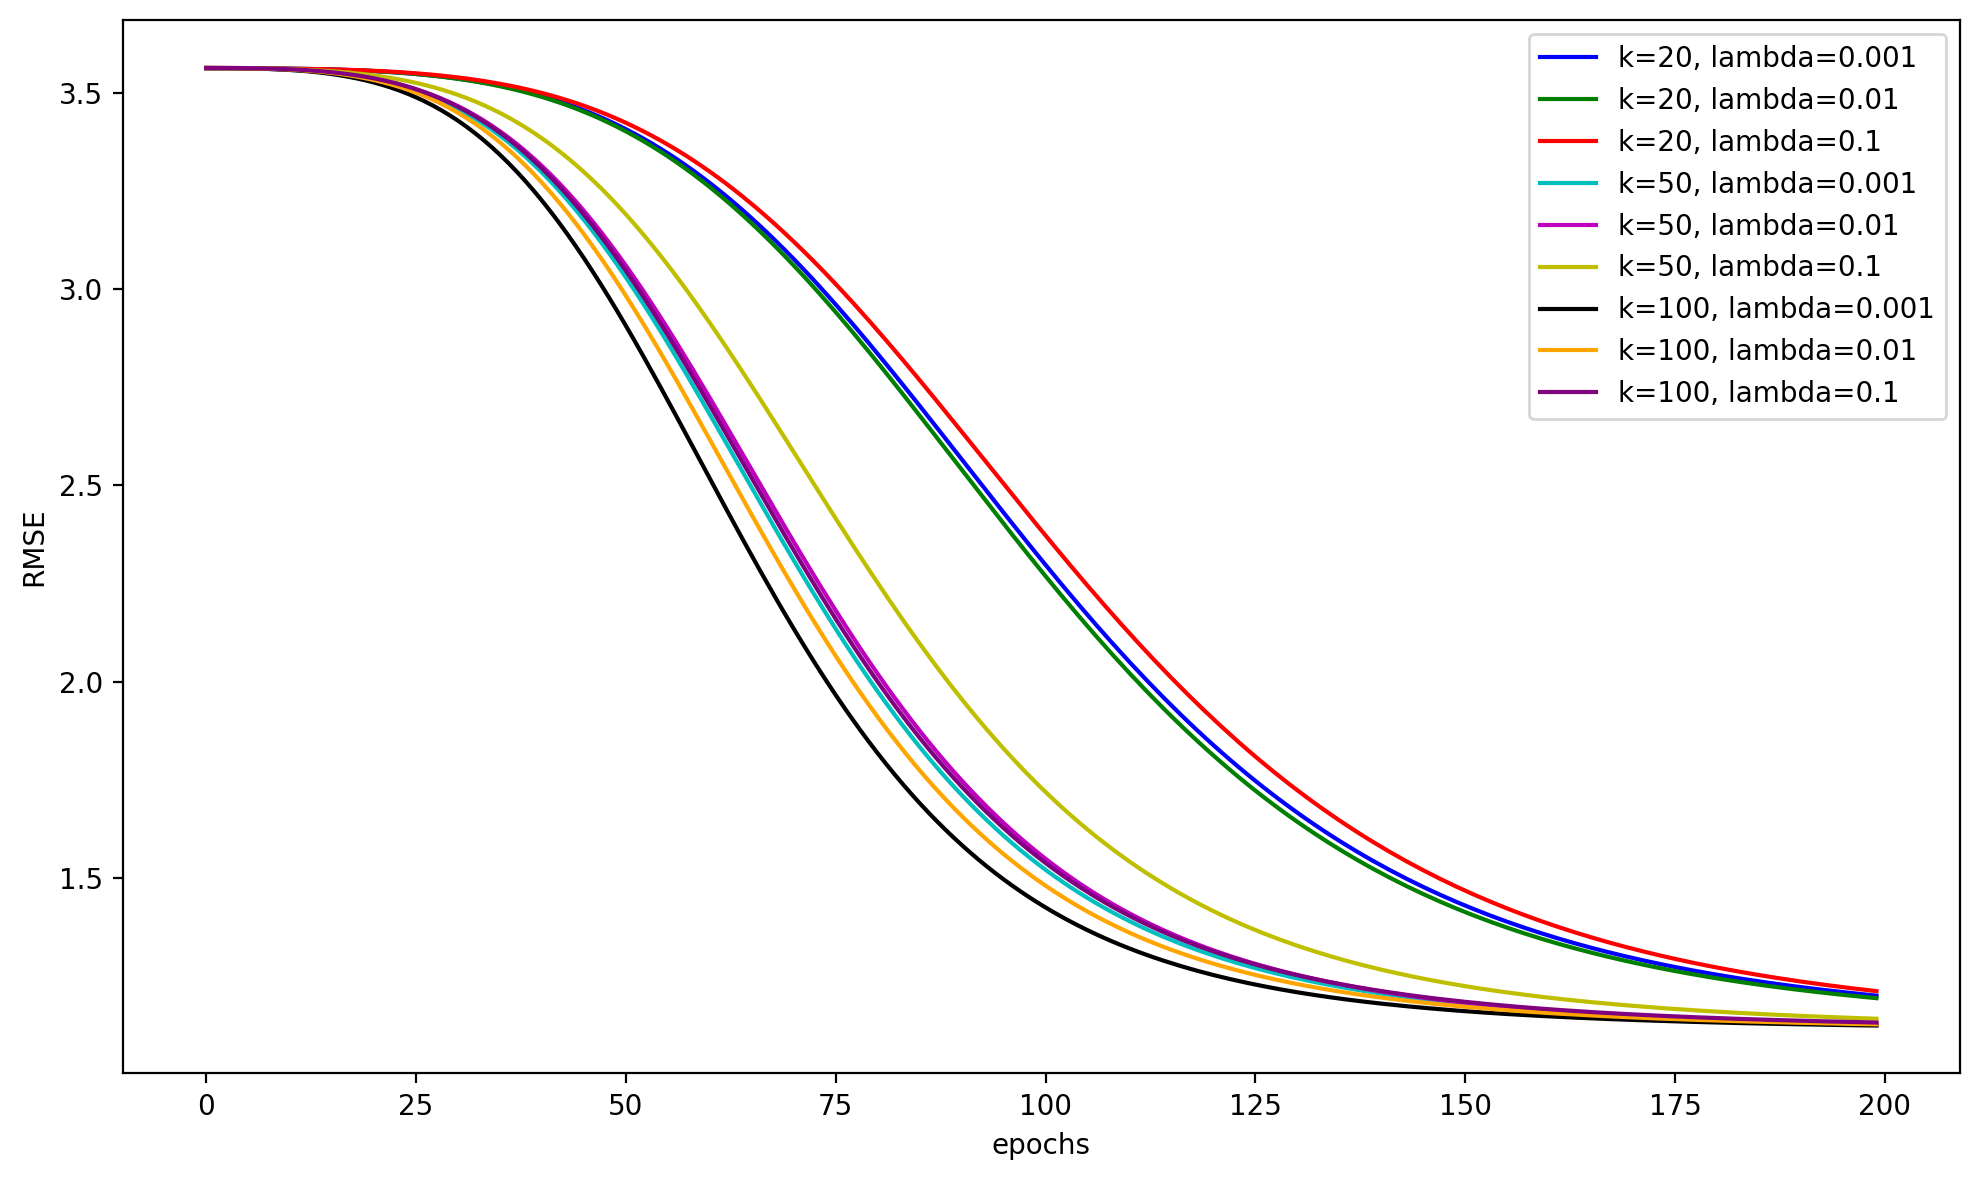

In [190]:
def plot_multi_RMSE(x, y, xl, yl, path):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple']

    plt.figure(figsize=(10, 6), dpi=200) 
    
    for (k, v), color in zip(y.items(), colors):
        plt.plot(x, v, label=f'k={k[0]}, lambda={k[1]}', color=color)
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(f"{path}.png")

plot_multi_RMSE(range(200), RMSEs, xl='epochs', yl='RMSE', path='RMSEs')